<a href="https://colab.research.google.com/github/JulienGenovese/My_work/blob/master/MNIST_dataset_an_explained_tutorial_in_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST DATASET ANALSYS**

We will work on the **MNIST dataset**, one of the most important one in the AI litterature. This dataset is composed by images of numbers from 0 to 9. We will try to classify them.

In this notebook we don't want to do a complete analysis on the methods that can be used on this problem. We only want to:

1. describe some techniques;
2. see the results;
3. try to explain them;


This work is divided in this way:
- Introduction to the problem and exploratory data analysis
- A machine learning approach with Logistic Regression and Random Forest
- A deep learning approach using Fully Connected Neural Network
- A data augmentation trial
- What to do next?

For further details contact juliengenovese@hotmail.it

# 1. **Introduction of the problem and exploratory data analysis**


### 1.1 **Import the library**

If we don't have the gpu-version of tensorflow installed let's start by that.

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 56kB/s 


Next import some of the libraries that we need later.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics


We want to see if the GPU is working. If we have a result with a number it's working, otherwise not.

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

If we want some other details on the hardware that we are using we can use the following command:

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5871664775136174683, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4708820212473186952
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15952598171207898654
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15677807680
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5077257661028542279
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

### 1.2 **Exploratory data analysis**

We import the MNIST dataset directly from Keras and we put the training set and test set into different ones. 

We have to say that the training set is not the best term to understand because it's better to call it the __learning set__. In fact we use it to learn the best model and this consist of a learning phase of different models using a part of it called __training set__ and a test phase on the remaining part called __dev set__ (or validation set). Finally, aften we chose the best model we use the __test set__ to have an idea of the real error without bias.

We cannot use the error estimated in the dev set because we have chosen the best model on the dev set and maybe we have overfitten it. So we need an unbiased set.

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Let's first do an exploratory data analysis to better understand our dataset.


In [ ]:
x_train.shape

(60000, 28, 28)

We see that we are working with 60000 images in a grey scale of 28x28 pixels.

In [ ]:
print(y_train.shape)
print(np.unique(y_train))

(60000,)
[0 1 2 3 4 5 6 7 8 9]


We see that we have 10 labels associated with 10 numbers.
Let's plot now some random examples:

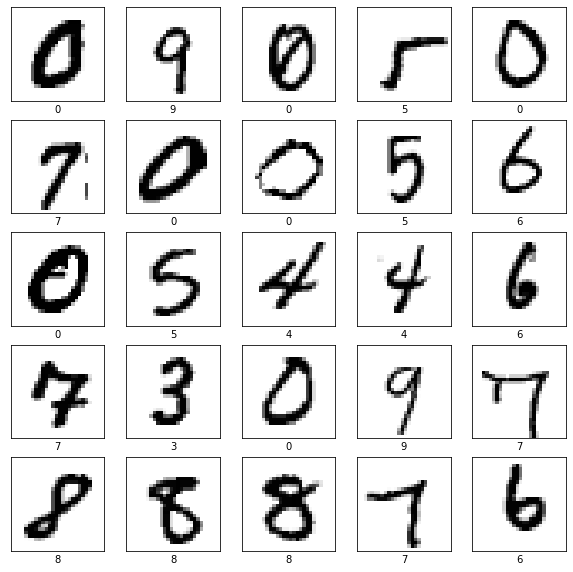

In [ ]:
plt.figure(figsize=(10,10))
np.random.seed(1)
for i in range(25):
    rn = np.random.randint(x_train.shape[0])
    plt.subplot(5,5,i +1 )
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_train[rn], cmap=plt.cm.binary)
    plt.xlabel(y_train[rn])
plt.show()

Another thing very important is to understand if the dataset is balanced.

[[0.         0.09871667]
 [1.         0.11236667]
 [2.         0.0993    ]
 [3.         0.10218333]
 [4.         0.09736667]
 [5.         0.09035   ]
 [6.         0.09863333]
 [7.         0.10441667]
 [8.         0.09751667]
 [9.         0.09915   ]]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


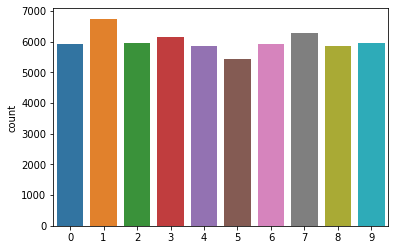

In [ ]:
y_train 
y = np.bincount(y_train)
ii = np.nonzero(y)[0]
print(np.vstack((ii,y[ii]/len(y_train))).T)
sns.countplot(y_train)

As we can see it's completely balanced. We don't need [particular techniques ](https://machinelearningmastery.com/what-is-imbalanced-classification/) to deal with it. 

### 1.3 **Normalization of the data**


In most of the machine and deep learning algorithms we need to normalize our data. 

In this case we will work with three algorithms:


1.   Random Forest
2.   Logistic regression
3.   Fully connected neural network

In the first case if we normalize or not it's the same. 

For the second and third one the normalization is important.

But why we normalize in that case? A very interesting [article](https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d) give a very good answer when we are working with a Neural Network. The normalization for logistic regression is quite a classical topic and can be found in a statistical learning book.

The idea is the following that we are going to explain.

We will use a particular explaination that we can generalize.

Let's suppose we are working with a logistic classificator. As we know in a fully connected network we can think each layer as a combination of different logistic classifiers but differently to them we usually don't use the sigmoid for the non-linearity part. In any case the sigmoid will be useful to understand.

To explain the reason of the normalization we remind that if $w_i$ is a weight of the netword we update the step $n$ using the gradient descent:
$$
w_i^n = w_i^{n-1} - \alpha \cdot \frac{\partial \textit{L}}{\partial w_i}
$$
and if we use the sigmoid as the non-linearity we have:
$$
\frac{\partial \textit{L}}{\partial w_i} = x_i \cdot (a - y)
$$
where $a$ is the prediction a the $(n-1)$ th step and $y$ the label associated to $\textbf{x} = (x_1, x_2, x_3, ...)$. So we see that $x_i$ control the amount of learning. If we have more information the learning will be bigger, slower otherwise. But in general it's not a good strategy to control the learning in this way so we have to normalize $x_i$. We cannot reduce $\alpha$ because it's operate uniformly on each feature.

The idea is similar changing the loss, because in all cases the derivative will be:
$$
\frac{\partial \textit{L}}{\partial w_i} = x_i \cdot \frac{\partial \textit{L}}{\partial z_i} 
$$
where $z = \textbf{x}^T\cdot \textbf{w}$ with $\textbf{w}$ the vector of weights.\\

Talking about the effect of the normalization from the image resolution point of view we can see [here](https://aishack.in/tutorials/normalized-rgb/) an example.


Therefore we normalize our data by the maximum possible pixel value:


In [ ]:
x_train = x_train/255
print(x_train.shape)
x_test = x_test /255
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


# 2. **A machine learning approach with Logistic Regression and Random Forest**


Now we reshape the image to flatten it and take it as a row vector.

We pass from $(60000, 28, 28)$ to $(60000, 28 \times 28)$.

This is a necessary step to input the image into a machine learning model.


In [ ]:
x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))
print(x_train_reshaped.shape)
print(x_train_reshaped[0,500:520])

(60000, 784)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.18039216 0.50980392]


### 2.1 **Logistic Regression**

We will not explain here the binary logistic classifier but we suggest the lecture of [this book](http://faculty.marshall.usc.edu/gareth-james/ISL/).

In particular we will use the approach of One-vs-Rest for the multiclass classification.
To better understand how to pass from the classical algorithm for binary classification to the multiclass we suggest [this](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/).


In [ ]:
from sklearn.linear_model import LogisticRegression

We start training our algorithm finding first the accuracy using a part of the dataset and using a cross-validation approach. In this way we have a solid idea of the test error and in the end we will use it to select the best model.

In [ ]:
modelLogisticOVR = LogisticRegression(multi_class='ovr')
cross_val_score(modelLogisticOVR, x_train_reshaped, y_train, cv = 3, n_jobs = -1, scoring = "accuracy")

array([0.91165, 0.91235, 0.91685])

We see an accuracy aroung $91.2\%$.

Let's use now all the training set.

In [ ]:
# fit model
modelLogisticOVR.fit(x_train_reshaped, y_train)

Predict the result for the train set and analyze the results:


In [ ]:
y_pred = modelLogisticOVR.predict(x_train_reshaped)

To understand if it's a good result we can compare it with the random guessing that can be seen as a benchmark in a balanced classification problem. We have 10 classes so the random guessing classifier has a score of 1/10 = 0.1

So comparing to result to our algorithm result (cross-validation result) we can see that the logistic regressor is learning something.

Let's see if some particular patters are present in the errors, plotting the misclassified images with the [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) and the confusion matrix normalized by row (therefore by the number of elements in each class).

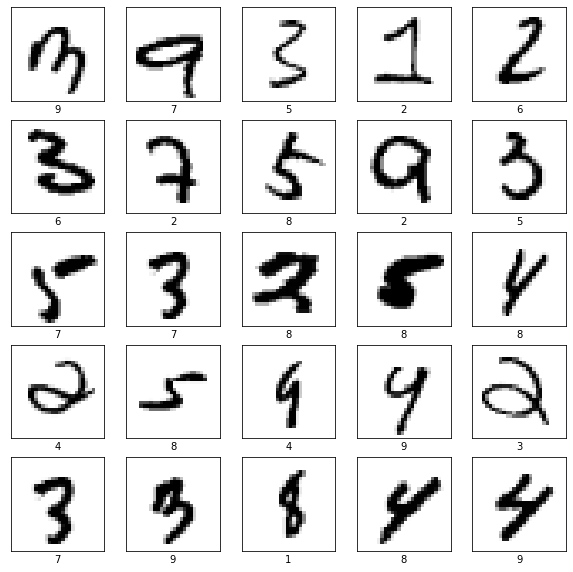

In [ ]:
incorrects = np.nonzero(y_pred != y_train)
x_incorrect = x_train[incorrects]
y_incorrect = y_pred[incorrects]
plt.figure(figsize=(10,10))
for i in range(25):
    rn = np.random.randint(x_incorrect.shape[0])
    plt.subplot(5,5,i +1 )
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_incorrect[rn], cmap=plt.cm.binary)
    plt.xlabel(y_incorrect[rn])
plt.show()

We can see that sometimes it's easy to see the error, because our algorithm is very related with the pixel position. 

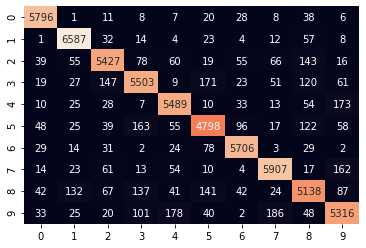

In [ ]:
sns.heatmap(confusion_matrix(y_train, y_pred), 
                    annot=True, cbar=False, fmt='d')

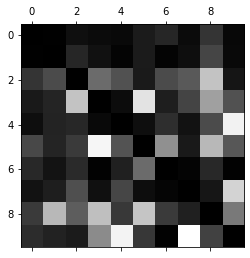

In [ ]:
conf_mx = confusion_matrix(y_train, y_pred)
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

From this confusion matrix we can see that maybe it's harder to predict the 8, the 5, the 2 and the 9.

In any case we don't see a particular pattern in the error so the problem is probably due to underfitting, i.e. our algorithm is not capturing all the pattern in the image.

### 2.2 **Random Forest**

We will not explain here the random forest, so we suggest the lecture of [this book](http://faculty.marshall.usc.edu/gareth-james/ISL/).


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In this case we need to do parameter tuning over some parameters. We can see a good guide on [this page](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/).

In particular we will focus on the number of trees and the number of features we give to each tree.

In [ ]:
param_grid = {
    'max_features': ['max_features','log2', 'sqrt'],
    'n_estimators': [100, 500, 1000]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(x_train_reshaped,y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 104.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
grid_search.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

The best features seem to be:

```
#{'max_features': 'sqrt', 'n_estimators': 1000}
```



Let's now train the best algorithm and analyze the cross-validation score.





In [ ]:
rfc = RandomForestClassifier(n_estimators=1000, max_features = "sqrt", n_jobs= -1)

In [ ]:
cross_val_score(rfc, x_train_reshaped, y_train, cv = 3, n_jobs = -1, scoring = "accuracy")

array([0.9675 , 0.96485, 0.96865])

In that case we see a result around 96.5% of accuracy.

Let's train on the whole dataset and analyze the results.


In [ ]:
rfc.fit(x_train_reshaped, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rfc.predict(x_train_reshaped)

In [ ]:
incorrects = np.nonzero(y_pred != y_train)
print(incorrects)

(array([], dtype=int64),)
[5 0 4 1 9]
[5 0 4 1 9]


Seeing the result we can also suspect an overfitting of the training set. 

# 3. **A deep learning approach using Fully Connected Neural Network**


Let's now pass to fully connected neural networks to see if our predictions can be improved. 

We will do different experiments:

1. **Change the optimization method**: stochastic gradient descent and Adam.
2. **Regularization**: we will try to use some regularization techniques like dropout and penalization methods.
3. **Change the dimensions of the network**: change the number of layers and the number of neurons.
4. **Hyper-parameter tuning**: we select the best parameters for the selected optimization method.
5. **Change the batch size of the mini-batch size and epochs**: change the number of images that we give in input to the optimization algorithm for each upgrading and the number of epochs we use to train.

We suggest [this lecture](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) for a complete tutorial on hyper parameter tuning for deep learning.

### 3.1 **Change the optimization method**

Let's start creating this very simple architecture:


1.   __Flatten layer__: used only to flatten the input. We don't need parameters.
2.   __One dense layer with relu activation__: used to learn some non-linearity.
3.  __One dense layer with sigmoid activation__: used to predict the output with a "probability" idea.

It's quite a classical structure but it's enough to do some experiments.

We want to compare the __Stochastic Gradient Method__ with the __Adam__ one.



In [ ]:
modelSGD = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(10, activation = 'sigmoid')
])

The next step is to write the details for the optimization algorithm so we want to remind some details.

First our goal is to optimize a loss for multiclass classification w.r.t. the weight matrices and bias.

For this purpose we will use a __sparse categorical Croos Entropy loss__ that we define as:
\begin{align}
J(W^{[1]}, b^{[1]}, ..., W^{[n]}, b^{[n]}) = 
& \dfrac{1}{m}\sum_{i = 0}^{m}\mathcal{L}\big(\hat{y}_i(W^{[1]}, b^{[1]}, ..., W^{[n]}, b^{[n]}), y_i\big)= \\ 
& \dfrac{1}{m}\sum_{i = 0}^{m}- \big (\sum_{i = 0}^{n^{[L]}}y^{(i)}_j log(\hat{y}^{(i)}_j)   \big)
\end{align}
where $n^{[L]}$ is the number of classes and $m$ the number of images, $y^{(i)}_j $ is the real label associated to the image $i$ and $\hat{y}^{(i)}_j$ the predicted one. 

As we know the goal is to find the parameters that minimize this loss function. 
We will use two different techniques to solve the optimization problem associated.


We will start with the __Stochastic Gradient Descent__ approach to see the oscillations of this method. 

But before let's remind the __gradient descent method__.

If we have a function $J(\textbf{w}, b)$ to minimize, the gradient descent method use this upgrade rule from step $n-1$ to $n$ :
$$
\begin{cases}
& \textbf{w}^{n} = \textbf{w}^{n-1} - \alpha \nabla_{\textbf{w}}J(\textbf{w}, b)|_{(\textbf{w}^{n-1}, b)}\\
& b^{n} = b^{n-1} - \alpha \dfrac{\partial J(\textbf{w}, b)}{\partial b}|_{(\textbf{w}^{n-1}, b)}
\end{cases}
$$
where $J(\textbf{w}, b) = \dfrac{1}{m}\sum_{i = 0}^{m}\mathcal{L}\big(\hat{y}_i(\textbf{w}, b), y_i\big)$ and $\alpha$ is a constant.

What we can do is to use all the images and do all the computations before upgrading our parameters (__classical gradient descent method__), or on the contrary use only one image (__stochastic gradient descent method__) or only one part of them (__mini-batch gradient descent method__).

With the classical approach you have a garantees to the convergence towards a local minima, but you need a lot of iterations before to converge and maybe you have a lot of images. If you go far from this theoretical approach, as in the stochastic and mini-batch case, you have no garantee to converge and you can oscillate. Let's see it.

In [ ]:
modelSGD.compile(optimizer=keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Now we have to fit the model on the training set. We give the number of epochs that is the number of times we see the training set in the learning phase. We add a validation split to evaluate the underfitting and the overfitting. The number of epochs is not too big because as we will see we don't have big changes after 20.

In [ ]:
historySGD = modelSGD.fit(x_train, y_train, validation_split = 0.33, epochs = 20)

Epoch 1/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5443 - accuracy: 0.9242 - val_loss: 1.5467 - val_accuracy: 0.9218
Epoch 2/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5435 - accuracy: 0.9248 - val_loss: 1.5461 - val_accuracy: 0.9226
Epoch 3/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5427 - accuracy: 0.9254 - val_loss: 1.5453 - val_accuracy: 0.9225
Epoch 4/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5419 - accuracy: 0.9260 - val_loss: 1.5447 - val_accuracy: 0.9233
Epoch 5/20
1257/1257 [==============================] - 3s 2ms/step - loss: 1.5412 - accuracy: 0.9262 - val_loss: 1.5440 - val_accuracy: 0.9239
Epoch 6/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5404 - accuracy: 0.9262 - val_loss: 1.5435 - val_accuracy: 0.9246
Epoch 7/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5397 - accuracy: 0.9272 - val_loss: 1.5428 - val_accuracy:

Let's see the loss and accuracy plot for both train and validation set.

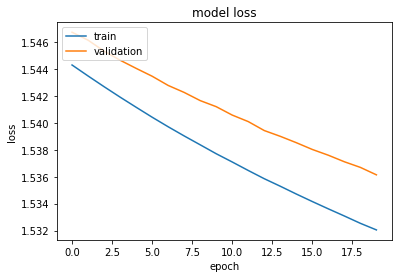

In [ ]:
plt.plot(historySGD.history['loss'])
plt.plot(historySGD.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

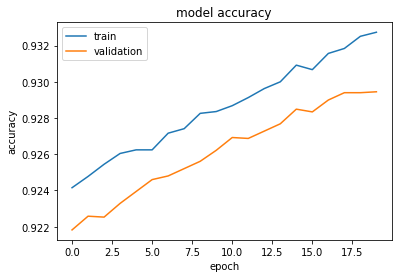

In [ ]:
plt.plot(historySGD.history['accuracy'])
plt.plot(historySGD.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We can see some overfitting that we will try to solve with some regularization methods later.

Now let's move towards the Adam Optimization algorithm. 
The main difference with the __SGD__ method is that we don't upgrade the weights with each image but we use what we call a _mini batch_, a sample of images. In this case we update less frequently that before but we are more similar to the classical gradient descent method. So we have some oscillations, less than before, that we try to remove using two other parts in the equations: 
1.   We add the __momentum part__ that use a weighted local average on the weights, trying to extract only the right direction and remove the oscillating part.
2.   We add the __RMS part__ that removes the oscillating parts using a weighted local average on the gradients.


We will start with some classical values and we will fine-tune it later. 


We use:


1.   $\alpha = 0.001$: very slow learning, but we avoid oscillations related with a too big learning rate. 
2.   $\beta_1 = 0.9$: not too big to avoid to learn nothing from the current iteration but enough to carry previous values and avoid oscillations.
3. $\beta= 0.999$: trying to give small possibilities to oscillate in the wrong direction. 
4. batch size of 32 images

Usually we have to introduce a $\varepsilon$ to avoid numerical instability due to small numbers, but it's usually put at $10^{-8}$.



In [ ]:
modelADM = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation = 'sigmoid')
])

In [ ]:
modelADM.compile(optimizer=keras.optimizers.Adam(
   learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We define the batch size as 32, so we elaborate 32 images at time.

In [ ]:
history = modelADM.fit(x_train, y_train, validation_split=0.33, epochs=20, batch_size = 32)

Epoch 1/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5878 - accuracy: 0.8940 - val_loss: 1.5306 - val_accuracy: 0.9310
Epoch 2/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5201 - accuracy: 0.9420 - val_loss: 1.5146 - val_accuracy: 0.9446
Epoch 3/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.5050 - accuracy: 0.9560 - val_loss: 1.5055 - val_accuracy: 0.9552
Epoch 4/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.4963 - accuracy: 0.9632 - val_loss: 1.5007 - val_accuracy: 0.9595
Epoch 5/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.4902 - accuracy: 0.9696 - val_loss: 1.4993 - val_accuracy: 0.9604
Epoch 6/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.4860 - accuracy: 0.9743 - val_loss: 1.4961 - val_accuracy: 0.9657
Epoch 7/20
1257/1257 [==============================] - 3s 3ms/step - loss: 1.4827 - accuracy: 0.9777 - val_loss: 1.4937 - val_accuracy:

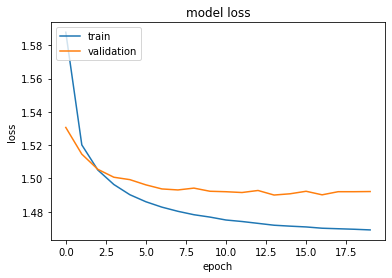

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

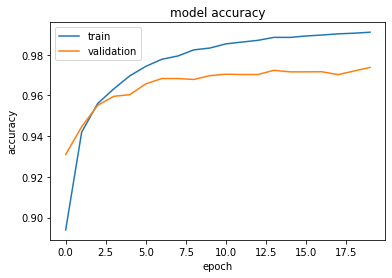

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We can see from the SGD method that we don't explicitly see the oscillations because we are only seeing the effects for each epoch and not at each iteration.

But we note that the convergence to a small value of the loss is faster for the ADAM method because we have removed the oscillations.
It's here that we see the fact that we have less oscillations.
But we also see the better validation accuracy in the Adam method due to the fact that the SGD is oscillating around the minimum but doesn't reach it. 

Finally we can see a possible overfitting due to the difference between the accuracy in the validation set and the training set, both in the loss and in the accuracy. But this can be also related with a difficulty of predicting the validation set. We will try to descover the real motivation trying to remove the overfitting it there is. 

Let's move on the error analysis part.

In [ ]:
y_pred_train = modelADM.predict(x_train)

Let's see a heat map to understand the uncertainty of the classification.

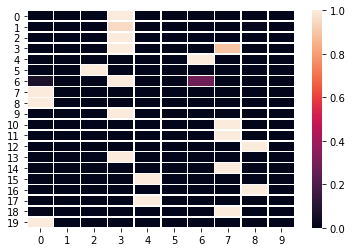

In [ ]:
lst = [np.random.randint(0, y_pred_train.shape[0]) for x in range(20)]
ax = sns.heatmap(y_pred_train[lst,], linewidth=0.5)
plt.show()

We see that the classifier is quite sure of the class for these images. Good sign!

Let's see the confusion matrix to see the most commun errors.


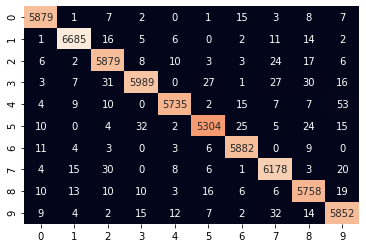

In [ ]:
y_pred = np.argmax(y_pred_train, axis = 1 )
sns.heatmap(confusion_matrix(y_train, y_pred), 
                    annot=True, cbar=False, fmt='d')

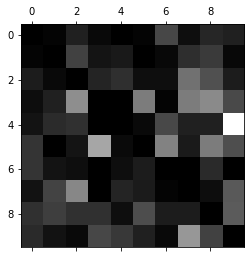

In [ ]:
y_pred = np.argmax(y_pred_train, axis = 1 )
conf_mx = confusion_matrix(y_train, y_pred)
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

So we see some pattern in the error, as the 4 with the 9, the 7 with the 2, 3 with the 5, and in general the 8.
The eight is difficult due to its shape that can be confused with the 3 and the 5.

We can now understand that the eight is easy to confuse because is similar to different numbers.


Let's try to modify our network introducing some regularization techniques like __dropout__ and __penalization methods__ and trying next to expand the network with and without regularization. 

## 3.2 **Regularization** 

The regularization is in general a way to simplify a model introducing some penalties or on the structure of the network (dropout) or on the weights ($L_2$ and $L_1$ regularization). 

The difficulty with the regularization is to find the right quantity of penalty without finishing in the underfitting problem.

### 3.2.1 **Dropout**

With this technique we turn off some neurons at random in the training phase and we recover all of them in the test phase. 

The reason to do it are several and in particular:


1.   It forces each node to not rely on some particular other nodes avoinding the phenomena called _coadaptation_.
2.   It learns using a simpler network introducing a regularization effect.

It works in the following way:


*   In the training phase, during each epoch we turns off some neurons with a probability $p$ and each weight is divided by the probability, i.e. $W_{ij}/p$. This normalization is done because otherwise having removed some of the nodes the expected values of the weights would be lower. This is a raw way to recover the expected value.
*   In the test phase we recover all the neurons and we remove the normalization of the weights.


In [ ]:
def myModelDrop(dropout = 0.5):
  modelADMDrop = tf.keras.Sequential()
  modelADMDrop.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  modelADMDrop.add(tf.keras.layers.Dense(128, activation='relu'))
  modelADMDrop.add(tf.keras.layers.Dropout(dropout))
  modelADMDrop.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  modelADMDrop.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return modelADMDrop

Let's try 3 different values of dropout.

In [ ]:
dropout = [0.2, 0.5, 0.7]
param_gridDrop = dict(dropout = dropout)

Let's use a 3-fold cross-validation. In general the results will be more unstable than a 10-fold cross validation but we have a lot of data in each validation fold and so it will be pretty stable and in addition it will require less computation. 

In [ ]:
modelDrop = KerasClassifier(build_fn = myModelDrop, epochs=20, batch_size=32, verbose=0)
gridDrop = GridSearchCV(estimator=modelDrop, param_grid = param_gridDrop , cv=3, verbose = 1)
grid_result_drop = gridDrop.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.4min finished


In [ ]:
print("Best: %f using %s" % (grid_result_drop.best_score_, grid_result_drop.best_params_))

Best: 0.971950 using {'dropout': 0.2}


The result make sense. If fact we don't have seen a big overfit on the data, so also the dropout coefficient will be small because we don't need to reduce to much the number of neurons.

In [ ]:
modelADMDrop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation = 'sigmoid')
])

In [ ]:
modelADMDrop.compile(optimizer=keras.optimizers.Adam(
   learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
historyADMDrop = modelADMDrop.fit(x_train, y_train, validation_split=0.33, epochs=30, batch_size = 32)

Epoch 1/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.6027 - accuracy: 0.8824 - val_loss: 1.5321 - val_accuracy: 0.9328
Epoch 2/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5292 - accuracy: 0.9331 - val_loss: 1.5161 - val_accuracy: 0.9456
Epoch 3/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5148 - accuracy: 0.9483 - val_loss: 1.5084 - val_accuracy: 0.9516
Epoch 4/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5062 - accuracy: 0.9561 - val_loss: 1.5027 - val_accuracy: 0.9571
Epoch 5/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5004 - accuracy: 0.9611 - val_loss: 1.5000 - val_accuracy: 0.9599
Epoch 6/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4963 - accuracy: 0.9659 - val_loss: 1.4973 - val_accuracy: 0.9637
Epoch 7/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4925 - accuracy: 0.9698 - val_loss: 1.4956 - val_accuracy:

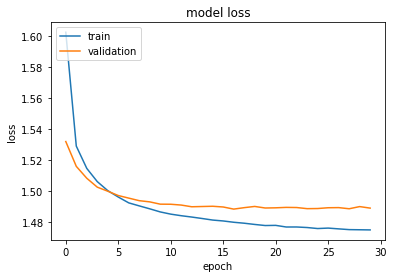

In [ ]:
plt.plot(historyADMDrop.history['loss'])
plt.plot(historyADMDrop.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

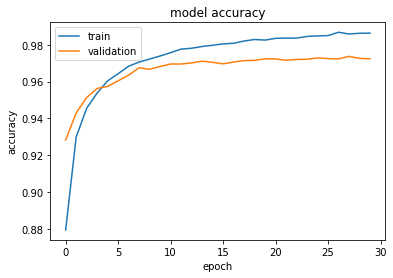

In [ ]:
plt.plot(historyADMDrop.history['accuracy'])
plt.plot(historyADMDrop.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We see that we have removed a part of overfitting. But also the training set has a bigger error. This is due to the fact that recognize the image using less neurons is easier.

See the validation error we don't see big improvement. 

Let's do an error analysis.

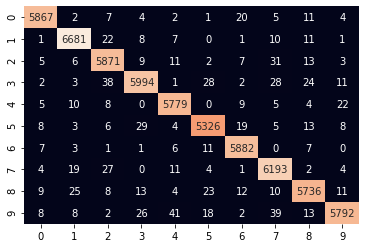

In [ ]:
y_pred_train = modelADMDrop.predict(x_train)
y_pred = np.argmax(y_pred_train, axis = 1 )
sns.heatmap(confusion_matrix(y_train, y_pred), 
                    annot=True, cbar=False, fmt='d')

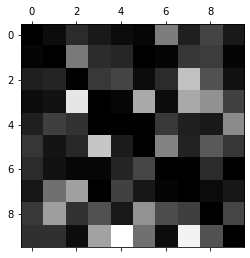

In [ ]:
y_pred = np.argmax(y_pred_train, axis = 1 )
conf_mx = confusion_matrix(y_train, y_pred)
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

From the confusion matrix we see some bigger error than before. 

We see less error betweeen 4 and 9.




### 3.2.2 **Penalization methods**

In this case we introduce some penalization on the weights, or $L_2$ or $L_1$ or both. We will focus on the $L_2$ one. For a general approach and the implementation of different penalized method see [here](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/#:~:text=The%20most%20common%20type%20of,range%20between%200%20and%200.1.).

The idea behind the $L_2$ penalization is to add a penalty for each unit of weight that we introduce in the model. We can explain this sentence by: "Do you want this weight? You have to pay for it. So it has to give you something in return".

Let's see it matematically.

In the penalized method we add the penalization to the loss:
\begin{align}
&J(W^{[1]}, b^{[1]}, ..., W^{[n]}, b^{[n]}) = \\
& \dfrac{1}{m}\sum_{i = 0}^{m}\mathcal{L}\big(\hat{y}_i(W^{[1]}, b^{[1]}, ..., W^{[n]}, b^{[n]}), y_i\big) + \dfrac{\lambda}{2m}\sum_{l=1}^{m}||W^{[l]}||_F^2\\
 \end{align}
 where $\sum_{l=1}^{m}||W^{[l]}||_F^2 = \sum_{i = 1}^{n^l}\sum_{j = 1}^{n^{[l-1]}}\big(W_{ij}^{[l]}\big)^2$ that is the Frobenious norm and in practice is a classical Euclidean norm.
 
In the $L_1$ case we only add the $L_1$ norm of $W$: $$||W||_{L_1}=  \sum_{i = 1}^{n^l}\sum_{j = 1}^{n^{[l-1]}}|W_{ij}|.$$

So in the gradient descent this reflect on:
$$
\nabla_W J = \nabla_W J_{from backprop} + \dfrac{\lambda}{m}W^{[l]}
$$
and 
$$
W^{[l]}= W^{[l]}- \alpha \nabla_W J
$$
and using these two last results together we obtain:
\begin{align}
& W^{[l]}= W^{[l]}- \alpha ( \nabla_W J_{from backprop} + \dfrac{\lambda}{m}W^{[l]}) = \\
& \big(1-\alpha \dfrac{\lambda}{m}\big)W^{[l]}- \alpha \nabla_W J_{from backprop} 
\end{align}
and $\big(1-\alpha \dfrac{\lambda}{m}\big) < 1 $ and therefore the penalization will always results in smaller weights than without it. 

In particular the idea is that we will have only weights that can improve the results lowering the loss. 
The last thing to say is that the penalization will put the unnecessary weights near to zero in the $L_2$ case and to zero in the $L_1$ and this will result in a simpler network.

In [ ]:
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
param_gridPen = dict(l_2_penalty = values)

In [ ]:
def myModelpen(l_2_penalty):
  modelADMpen = tf.keras.Sequential()
  modelADMpen.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  modelADMpen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l_2_penalty)))
  modelADMpen.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  modelADMpen.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return modelADMpen


In [ ]:
modelPen = KerasClassifier(build_fn = myModelpen, epochs=20, batch_size=32, verbose=0)
gridPen = GridSearchCV(estimator = modelPen, param_grid = param_gridPen , cv=3, verbose = 1)
grid_result_pen = gridPen.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.3min finished


In [ ]:
print("Best: %f using %s" % (grid_result_pen.best_score_, grid_result_pen.best_params_))

Best: 0.973283 using {'l_2_penalty': 1e-05}


Let's train the best model.

In [ ]:
modelADMpen = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dense(10, activation = 'sigmoid')
])

In [ ]:
modelADMpen.compile(optimizer=keras.optimizers.Adam(
   learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
historyADMpen = modelADMpen.fit(x_train, y_train, validation_split=0.33, epochs = 30, batch_size = 32)

Epoch 1/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5937 - accuracy: 0.8966 - val_loss: 1.5371 - val_accuracy: 0.9306
Epoch 2/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5261 - accuracy: 0.9420 - val_loss: 1.5215 - val_accuracy: 0.9463
Epoch 3/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5130 - accuracy: 0.9546 - val_loss: 1.5143 - val_accuracy: 0.9541
Epoch 4/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5053 - accuracy: 0.9621 - val_loss: 1.5113 - val_accuracy: 0.9570
Epoch 5/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5000 - accuracy: 0.9671 - val_loss: 1.5086 - val_accuracy: 0.9604
Epoch 6/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4963 - accuracy: 0.9719 - val_loss: 1.5063 - val_accuracy: 0.9625
Epoch 7/30
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4938 - accuracy: 0.9751 - val_loss: 1.5029 - val_accuracy:

Let's see now the results.

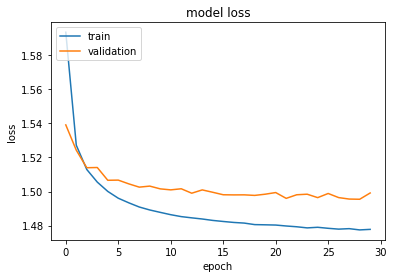

In [ ]:
plt.plot(historyADMpen.history['loss'])
plt.plot(historyADMpen.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

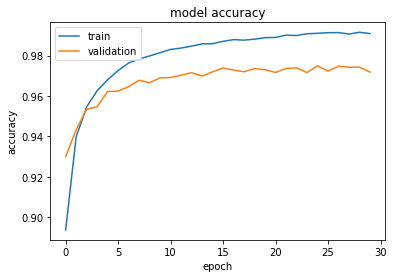

In [ ]:
plt.plot(historyADMpen.history['accuracy'])
plt.plot(historyADMpen.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

So at the end we don't see very big changes using the regularization techniques. We only see a $0.1/%$ of improvement.

This is probably due to the fact that our network is too simple and can not completely benifit from these methods. 

When we will use more complex structure we will try to use them again.

## 3.3 **Change the dimensions of the Network**

Let's now pass to one of the most important part: the decision of the size of the network. We will try to:

1. Change the number of layers.
2. Change the number of neurons in each layer.

### 3.4.1 **Change the number of layers**

We start with 4 layers.

In [ ]:
def myModel4L():
  model4L = tf.keras.Sequential()
  
  model4L.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  model4L.add(tf.keras.layers.Dense(128, activation='relu'))
  model4L.add(tf.keras.layers.Dense(128, activation='relu'))
  model4L.add(tf.keras.layers.Dense(128, activation='relu'))

  model4L.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  model4L.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return model4L

In [ ]:
model4L = myModel4L()
history4L = model4L.fit(x_train, y_train, validation_split = 0.33, epochs = 20)

Epoch 1/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5584 - accuracy: 0.9025 - val_loss: 1.5079 - val_accuracy: 0.9463
Epoch 2/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5013 - accuracy: 0.9520 - val_loss: 1.4965 - val_accuracy: 0.9569
Epoch 3/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4904 - accuracy: 0.9645 - val_loss: 1.4939 - val_accuracy: 0.9597
Epoch 4/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4848 - accuracy: 0.9697 - val_loss: 1.4914 - val_accuracy: 0.9629
Epoch 5/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4807 - accuracy: 0.9760 - val_loss: 1.4890 - val_accuracy: 0.9666
Epoch 6/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4784 - accuracy: 0.9777 - val_loss: 1.4896 - val_accuracy: 0.9634
Epoch 7/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4772 - accuracy: 0.9788 - val_loss: 1.4902 - val_accuracy:

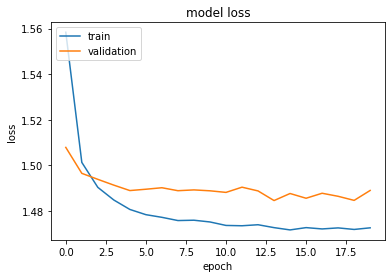

In [ ]:
plt.plot(history4L.history['loss'])
plt.plot(history4L.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Let's continue with 6 layers.

In [ ]:
def myModel6L():
  model6L = tf.keras.Sequential()
  
  model6L.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  model6L.add(tf.keras.layers.Dense(128, activation='relu'))
  model6L.add(tf.keras.layers.Dense(128, activation='relu'))
  model6L.add(tf.keras.layers.Dense(128, activation='relu'))
  model6L.add(tf.keras.layers.Dense(128, activation='relu'))
  model6L.add(tf.keras.layers.Dense(128, activation='relu'))

  model6L.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  model6L.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return model6L

In [ ]:
model6L = myModel6L()
history6L = model6L.fit(x_train, y_train, validation_split = 0.33, epochs = 20)

Epoch 1/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5640 - accuracy: 0.8678 - val_loss: 1.5093 - val_accuracy: 0.9393
Epoch 2/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5066 - accuracy: 0.9417 - val_loss: 1.5082 - val_accuracy: 0.9395
Epoch 3/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5009 - accuracy: 0.9499 - val_loss: 1.5035 - val_accuracy: 0.9472
Epoch 4/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4974 - accuracy: 0.9533 - val_loss: 1.5120 - val_accuracy: 0.9311
Epoch 5/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4965 - accuracy: 0.9540 - val_loss: 1.4982 - val_accuracy: 0.9525
Epoch 6/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4985 - accuracy: 0.9415 - val_loss: 1.5500 - val_accuracy: 0.8740
Epoch 7/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4952 - accuracy: 0.9525 - val_loss: 1.4977 - val_accuracy:

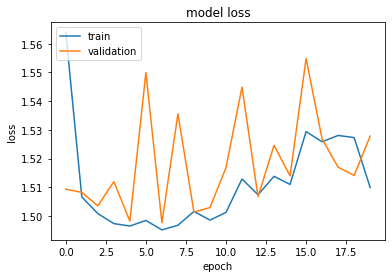

In [ ]:
plt.plot(history6L.history['loss'])
plt.plot(history6L.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We can clearly see the overfitting. Let's try to train another deeper network to better see this phenomena and after we will try to solve it.

8 layers.

In [ ]:
def myModel8L():
  myModel8L = tf.keras.Sequential()
  
  myModel8L.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  myModel8L.add(tf.keras.layers.Dense(128, activation='relu'))
  myModel8L.add(tf.keras.layers.Dense(128, activation='relu'))
  myModel8L.add(tf.keras.layers.Dense(128, activation='relu'))
  myModel8L.add(tf.keras.layers.Dense(128, activation='relu'))
  myModel8L.add(tf.keras.layers.Dense(128, activation='relu'))
  myModel8L.add(tf.keras.layers.Dense(128, activation='relu'))
  myModel8L.add(tf.keras.layers.Dense(128, activation='relu'))

  myModel8L.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  myModel8L.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return myModel8L

In [ ]:
model8L = myModel8L()
history8L = model8L.fit(x_train, y_train, validation_split = 0.33, epochs = 20)

Epoch 1/20
1257/1257 [==============================] - 4s 4ms/step - loss: 1.5785 - accuracy: 0.8494 - val_loss: 1.5197 - val_accuracy: 0.9276
Epoch 2/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5262 - accuracy: 0.9197 - val_loss: 1.5209 - val_accuracy: 0.9295
Epoch 3/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5483 - accuracy: 0.8804 - val_loss: 1.5276 - val_accuracy: 0.9229
Epoch 4/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5591 - accuracy: 0.8683 - val_loss: 1.5354 - val_accuracy: 0.9084
Epoch 5/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5852 - accuracy: 0.8174 - val_loss: 1.5429 - val_accuracy: 0.9008
Epoch 6/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5932 - accuracy: 0.8035 - val_loss: 1.6118 - val_accuracy: 0.7653
Epoch 7/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.6653 - accuracy: 0.6780 - val_loss: 1.6512 - val_accuracy:

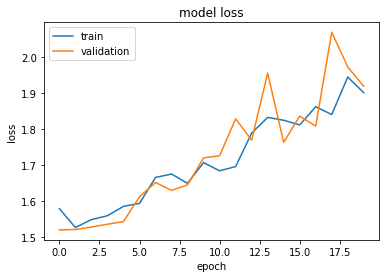

In [ ]:
plt.plot(history8L.history['loss'])
plt.plot(history8L.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

From the history training we see a very possible strong source of overfitting. 
Let's try to solve it using both dropout and penalization.

In [ ]:
def myModel8LPen(dropout, l2_pen):
  myModel8LPen = tf.keras.Sequential()
  
  myModel8LPen.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  myModel8LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel8LPen.add(tf.keras.layers.Dropout(dropout))
  myModel8LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel8LPen.add(tf.keras.layers.Dropout(dropout))
  myModel8LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel8LPen.add(tf.keras.layers.Dropout(dropout))
  myModel8LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel8LPen.add(tf.keras.layers.Dropout(dropout))
  myModel8LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel8LPen.add(tf.keras.layers.Dropout(dropout))
  myModel8LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel8LPen.add(tf.keras.layers.Dropout(dropout))
  myModel8LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel8LPen.add(tf.keras.layers.Dropout(dropout))

  myModel8LPen.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  myModel8LPen.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return myModel8LPen

In [ ]:
penalty = [0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
dropoutValues = [0.2, 0.5, 0.7]
param_gridReg = dict(l2_pen = penalty, dropout = dropoutValues)

In [ ]:
model8LPen = KerasClassifier(build_fn = myModel8LPen, epochs=20, batch_size=32, verbose=0)
gridPen8L = GridSearchCV(estimator = model8LPen, param_grid = param_gridReg , cv = 3, verbose = 1)
grid_result_8Lpen = gridPen8L.fit(x_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed: 58.1min finished


In [ ]:
print("Best: %f using %s" % (grid_result_8Lpen.best_score_, grid_result_8Lpen.best_params_))

Best: 0.874483 using {'dropout': 0.2, 'l2_pen': 0.0001}


We see that the techniques worked but the results are not good enough. We come back and try to regularize simpler models.

In [ ]:
def myModel6LPen(dropout, l2_pen):
  myModel6LPen = tf.keras.Sequential()
  
  myModel6LPen.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  myModel6LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel6LPen.add(tf.keras.layers.Dropout(dropout))
  myModel6LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel6LPen.add(tf.keras.layers.Dropout(dropout))
  myModel6LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel6LPen.add(tf.keras.layers.Dropout(dropout))
  myModel6LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel6LPen.add(tf.keras.layers.Dropout(dropout))
  myModel6LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel6LPen.add(tf.keras.layers.Dropout(dropout))
  

  myModel6LPen.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  myModel6LPen.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return myModel6LPen

In [ ]:
model6LPen = KerasClassifier(build_fn = myModel6LPen, epochs=20, batch_size=32, verbose=0)
gridPen6L = GridSearchCV(estimator = model6LPen, param_grid = param_gridReg , cv = 3, verbose = 1)
grid_result_6Lpen = gridPen6L.fit(x_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed: 50.1min finished


In [ ]:
print("Best: %f using %s" % (grid_result_6Lpen.best_score_, grid_result_6Lpen.best_params_))

Best: 0.960367 using {'dropout': 0.2, 'l2_pen': 0.0001}


Also in that case we see a big improvement with the regularization.

Let's try with the 4 layers network.


In [ ]:
def myModel4LPen(dropout, l2_pen):
  myModel4LPen = tf.keras.Sequential()
  
  myModel4LPen.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  myModel4LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel4LPen.add(tf.keras.layers.Dropout(dropout))
  myModel4LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel4LPen.add(tf.keras.layers.Dropout(dropout))
  myModel4LPen.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_pen)))
  myModel4LPen.add(tf.keras.layers.Dropout(dropout))
  
  myModel4LPen.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  myModel4LPen.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return myModel4LPen

In [ ]:
model4LPen = KerasClassifier(build_fn = myModel4LPen, epochs=20, batch_size=32, verbose=0)
gridPen4L = GridSearchCV(estimator = model4LPen, param_grid = param_gridReg , cv = 3, verbose = 1)
grid_result_4Lpen = gridPen4L.fit(x_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed: 42.2min finished


In [ ]:
print("Best: %f using %s" % (grid_result_4Lpen.best_score_, grid_result_4Lpen.best_params_))

Best: 0.970600 using {'dropout': 0.2, 'l2_pen': 1e-05}


In [ ]:
model4LPen = myModel4LPen(dropout = 0.2, l2_pen = 1e-05)
history4LPen = model4LPen.fit(x_train, y_train, validation_split = 0.33, epochs = 20)

Epoch 1/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5967 - accuracy: 0.8566 - val_loss: 1.5171 - val_accuracy: 0.9381
Epoch 2/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5208 - accuracy: 0.9370 - val_loss: 1.5060 - val_accuracy: 0.9543
Epoch 3/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5115 - accuracy: 0.9481 - val_loss: 1.5038 - val_accuracy: 0.9571
Epoch 4/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5062 - accuracy: 0.9545 - val_loss: 1.5028 - val_accuracy: 0.9605
Epoch 5/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5039 - accuracy: 0.9587 - val_loss: 1.5014 - val_accuracy: 0.9611
Epoch 6/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5015 - accuracy: 0.9618 - val_loss: 1.4982 - val_accuracy: 0.9664
Epoch 7/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.4999 - accuracy: 0.9648 - val_loss: 1.5015 - val_accuracy:

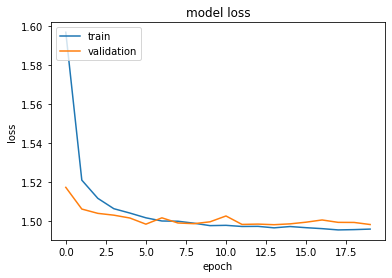

In [ ]:
plt.plot(history4LPen.history['loss'])
plt.plot(history4LPen.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We can see that we have removed a part of overfitting but we need few epocs.

Let's move on the tuning of the number of neurons.

### 3.4.2 **Change the number of neurons in each layer**


We will try to use 64, 128, 256 or 512 in each layer and see the results.

In [ ]:
def myModel4LNeurons(neurons):
  myModel4LNeurons = tf.keras.Sequential()
  
  myModel4LNeurons.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  myModel4LNeurons.add(tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LNeurons.add(tf.keras.layers.Dropout(0.2))
  myModel4LNeurons.add(tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LNeurons.add(tf.keras.layers.Dropout(0.2))
  myModel4LNeurons.add(tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LNeurons.add(tf.keras.layers.Dropout(0.2))
  
  myModel4LNeurons.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 =  0.9, beta_2 = 0.999, amsgrad = False)
  myModel4LNeurons.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return myModel4LNeurons

In [ ]:
neurons = [64, 128, 256, 512]
param_grid_neurons = dict(neurons = neurons)

In [ ]:
modelNeurons = KerasClassifier(build_fn = myModel4LNeurons, epochs=20, batch_size=32, verbose=0)
grid_neurons = GridSearchCV(estimator = modelNeurons, param_grid = param_grid_neurons, cv = 3, verbose = 1)
grid_result_neurons = grid_neurons.fit(x_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  8.0min finished


In [ ]:
print("Best: %f using %s" % (grid_result_neurons.best_score_, grid_result_neurons.best_params_))

Best: 0.970983 using {'neurons': 128}


Therefore, using 128 neurons we come back the previous models. Let's see the accuracy.

In [ ]:
model4LPenFinal = myModel4LNeurons(128)
model4LPenFinal.fit(x_train, y_train, validation_split = 0.33, epochs = 20)
model4LPenFinal.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5981 - accuracy: 0.8570 - val_loss: 1.5195 - val_accuracy: 0.9363
Epoch 2/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5226 - accuracy: 0.9336 - val_loss: 1.5066 - val_accuracy: 0.9533
Epoch 3/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5127 - accuracy: 0.9459 - val_loss: 1.5057 - val_accuracy: 0.9547
Epoch 4/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5076 - accuracy: 0.9536 - val_loss: 1.5039 - val_accuracy: 0.9592
Epoch 5/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5048 - accuracy: 0.9576 - val_loss: 1.5000 - val_accuracy: 0.9635
Epoch 6/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5024 - accuracy: 0.9605 - val_loss: 1.4985 - val_accuracy: 0.9655
Epoch 7/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5016 - accuracy: 0.9625 - val_loss: 1.5005 - val_accuracy:

[1.4957975149154663, 0.9732999801635742]

## 3.4 **Hyper-Parameter tuning**



In this last part we will take the two best algorithm that we have trained and will try to tune the parameter of the Adam Algorithm.

We don't use a grid because we have too many parameters and the computation cost would rise too much. 

A better technique is to take the parameter at random and after try to fine-tune around some zones. 

To take a random we are not saying that we take uniformly but we have to strategy that we explain for $\alpha$:


1.   To take 90% of the possible $\alpha$ between $0.1$ and $1$ and 10% between $0.0001$ and $0.1$.
2.   We take uniformly at random some values for $log(\alpha)$. So, First you specify a domain for a variable $r\in [-min, 0]$ that you sample it uniformly at random. After you take $10^{r_1}, 10^{r_2}, 10^{r_3}, ...$. The reason for this choice is to take an $\alpha$ with different orders of magnitude because we don't know how fast has to be the learning.

For $\beta_1$ and $\beta_2$ we use a similar strategy but we taking at random the values for $1-\beta_1, 1-\beta_2$. 

The reason in this case is related with the algorithm. Let's remind that in the Adam one these parameters are related with a local exponentially weighted average. Usually when we have a weight of the form $(1-\varepsilon)^{\varrho} $ we know that after $\varrho = \dfrac{1}{\varepsilon}$, so after $(1-\varepsilon)^{1/\varepsilon}$ the weights are less important in the average.

So supposing that we are finding a weight $\beta$ from $0.9$ to $0.999$, we have $1-\beta=0.1,..., 0.0001$.

If we take uniformly we give the same importance to pass from $0.9000$ to $0.9005$ and from $0.999$ to $0.9995$. In the first case the exponential average is always taking into account 10 steps but in the second case we pass from around 1000 steps to around 2000 steps, a big difference. So we have to refine in the second part and this is the reason because we are taking the logarithm for $\beta_1, \beta_2$ as well.




We first start with the more complex model.



In [ ]:
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
beta1 =  [1-0.001, 1-0.002,1- 0.005,1- 0.01, 1-0.1]
beta2 = [1-0.001,1- 0.002, 1-0.005, 1-0.01,1- 0.1]
param_grid_final = dict(learning_rate = learn_rate, beta_1 = beta1, beta_2 = beta2)

In [ ]:
def myModel4LFinal(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999):
  myModel4LNeurons = tf.keras.Sequential()
  
  myModel4LNeurons.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  myModel4LNeurons.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LNeurons.add(tf.keras.layers.Dropout(0.2))
  myModel4LNeurons.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LNeurons.add(tf.keras.layers.Dropout(0.2))
  myModel4LNeurons.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LNeurons.add(tf.keras.layers.Dropout(0.2))
  
  myModel4LNeurons.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate, beta_1, beta_2, amsgrad = False)
  myModel4LNeurons.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return myModel4LNeurons

In [ ]:
model4Lhp = KerasClassifier(build_fn = myModel4LFinal, epochs = 20, batch_size = 32, verbose=0)
grid4L_hp = GridSearchCV(estimator = model4Lhp, param_grid = param_grid_final, cv = 3, verbose = 1)
grid_result4L_hp = grid4L_hp.fit(x_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result4L_hp.best_score_, grid_result4L_hp.best_params_))

Best: 0.970767 using {'beta_1': 0.9, 'beta_2': 0.999, 'learning_rate': 0.001}


So for this model the best paramater are $\beta_1 = 0.9$, $\beta_2 = 0.999$, $\alpha = 0.001$. Let's train the model and see the confusion matrix.

In [ ]:
model4LFinal = myModel4LFinal(beta_1 = 0.9, beta_2 = 0.999, learning_rate = 0.001)
model4LFinal.fit(x_train, y_train, validation_split = 0.33, epochs = 20)

Epoch 1/20
1257/1257 [==============================] - 5s 4ms/step - loss: 1.5961 - accuracy: 0.8597 - val_loss: 1.5217 - val_accuracy: 0.9359
Epoch 2/20
1257/1257 [==============================] - 5s 4ms/step - loss: 1.5220 - accuracy: 0.9358 - val_loss: 1.5040 - val_accuracy: 0.9558
Epoch 3/20
1257/1257 [==============================] - 5s 4ms/step - loss: 1.5117 - accuracy: 0.9482 - val_loss: 1.5023 - val_accuracy: 0.9580
Epoch 4/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5070 - accuracy: 0.9545 - val_loss: 1.5004 - val_accuracy: 0.9619
Epoch 5/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5045 - accuracy: 0.9578 - val_loss: 1.5019 - val_accuracy: 0.9602
Epoch 6/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5022 - accuracy: 0.9618 - val_loss: 1.4986 - val_accuracy: 0.9664
Epoch 7/20
1257/1257 [==============================] - 4s 3ms/step - loss: 1.5004 - accuracy: 0.9639 - val_loss: 1.5017 - val_accuracy:

In [ ]:
y_pred_train = model4LFinal.predict(x_train)
y_pred = np.argmax(y_pred_train, axis = 1 )


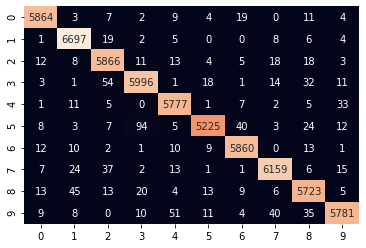

In [ ]:
sns.heatmap(confusion_matrix(y_train, y_pred), 
                    annot=True, cbar=False, fmt='d')

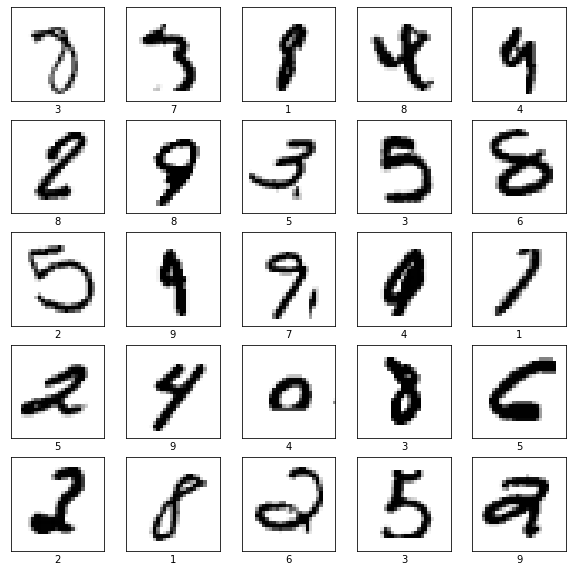

In [ ]:
incorrects = np.nonzero(y_pred != y_train)
x_incorrect = x_train[incorrects]
y_incorrect = y_pred[incorrects]
plt.figure(figsize=(10,10))
np.random.seed(1)
for i in range(25):
    rn = np.random.randint(x_incorrect.shape[0])
    plt.subplot(5,5,i +1 )
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_incorrect[rn], cmap=plt.cm.binary)
    plt.xlabel(y_incorrect[rn])
plt.show()

We can see that also from a human point of view some of them are impossible to understand. Let's see the loss and the accuracy.

Let's move on now on the simpler model.

In [ ]:
def myModel2Lfinal(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999):
  modelADMDrop = tf.keras.Sequential()
  modelADMDrop.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  modelADMDrop.add(tf.keras.layers.Dense(128, activation='relu'))
  modelADMDrop.add(tf.keras.layers.Dropout(0.5))
  modelADMDrop.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
  modelADMDrop.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return modelADMDrop

In [ ]:
model2Lhp = KerasClassifier(build_fn = myModel2Lfinal, epochs = 20, batch_size = 32, verbose=0)
grid2L_hp = GridSearchCV(estimator = model2Lhp, param_grid = param_grid_final, cv = 3, verbose = 1)
grid_result2L_hp = grid2L_hp.fit(x_train, y_train)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 176.9min finished


In [ ]:
print("Best: %f using %s" % (grid_result2L_hp.best_score_, grid_result2L_hp.best_params_))


Best: 0.963833 using {'beta_1': 0.9, 'beta_2': 0.998, 'learning_rate': 0.001}


Best parameters found are $\beta_1 = 0.9$ and $\beta_2 = 0.998$ e $\alpha= 0.001$.

In this case we have lost around 1% of accuracy with respect to the other model.

## 3.5 **Change the batch size of the mini-batch size and epochs**

In this last case we use the best model to tune the batch size. So we take:

In [ ]:
def myModel4LBatFinal():
  myModel4LBat = tf.keras.Sequential()
  
  myModel4LBat.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  
  myModel4LBat.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LBat.add(tf.keras.layers.Dropout(0.2))
  myModel4LBat.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LBat.add(tf.keras.layers.Dropout(0.2))
  myModel4LBat.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-05)))
  myModel4LBat.add(tf.keras.layers.Dropout(0.2))
  
  myModel4LBat.add(tf.keras.layers.Dense(10, activation = 'sigmoid'))
  optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
  myModel4LBat.compile(optimizer = optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
  return myModel4LBat

In [ ]:
batch_size = [32, 64, 128]
epochs = [10, 20, 40]
param_grid_bat = dict(batch_size = batch_size, epochs = epochs)


In [ ]:
model4Lbat = KerasClassifier(build_fn = myModel4LBatFinal, verbose=0)
grid4L_bat = GridSearchCV(estimator = model4Lbat , param_grid = param_grid_bat, cv = 3, verbose = 1)
grid_result4L_bat = grid4L_bat.fit(x_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 13.1min finished


In [ ]:
print("Best: %f using %s" % (grid_result4L_bat.best_score_, grid_result4L_bat.best_params_))

Best: 0.976150 using {'batch_size': 128, 'epochs': 40}


So the best model for the neural network is with 4 layers, regularized with batch size = 128 and number of epoch = 40.

In [ ]:
myFinalModel = myModel4LBatFinal()
myFinalModel.fit(x_train, y_train, validation_split = 0.33, epochs = 40, batch_size = 128)

Epoch 1/40
315/315 [==============================] - 1s 4ms/step - loss: 1.6599 - accuracy: 0.8120 - val_loss: 1.5275 - val_accuracy: 0.9302
Epoch 2/40
315/315 [==============================] - 1s 4ms/step - loss: 1.5326 - accuracy: 0.9267 - val_loss: 1.5103 - val_accuracy: 0.9480
Epoch 3/40
315/315 [==============================] - 1s 4ms/step - loss: 1.5173 - accuracy: 0.9427 - val_loss: 1.5046 - val_accuracy: 0.9544
Epoch 4/40
315/315 [==============================] - 1s 4ms/step - loss: 1.5082 - accuracy: 0.9521 - val_loss: 1.5020 - val_accuracy: 0.9583
Epoch 5/40
315/315 [==============================] - 1s 4ms/step - loss: 1.5031 - accuracy: 0.9582 - val_loss: 1.4988 - val_accuracy: 0.9622
Epoch 6/40
315/315 [==============================] - 1s 4ms/step - loss: 1.4997 - accuracy: 0.9629 - val_loss: 1.4975 - val_accuracy: 0.9642
Epoch 7/40
315/315 [==============================] - 1s 4ms/step - loss: 1.4968 - accuracy: 0.9665 - val_loss: 1.4962 - val_accuracy: 0.9667
Epoch 

So this is our best model, with $97.5\%$ of estimated accuracy.
Let's do a brief error analysis.

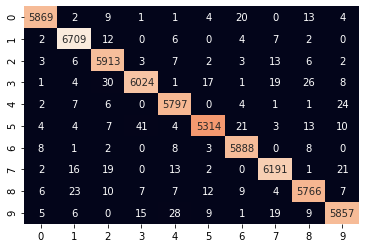

In [ ]:
y_pred_train = myFinalModel.predict(x_train)
y_pred = np.argmax(y_pred_train, axis = 1 )
sns.heatmap(confusion_matrix(y_train, y_pred), 
                    annot=True, cbar=False, fmt='d')

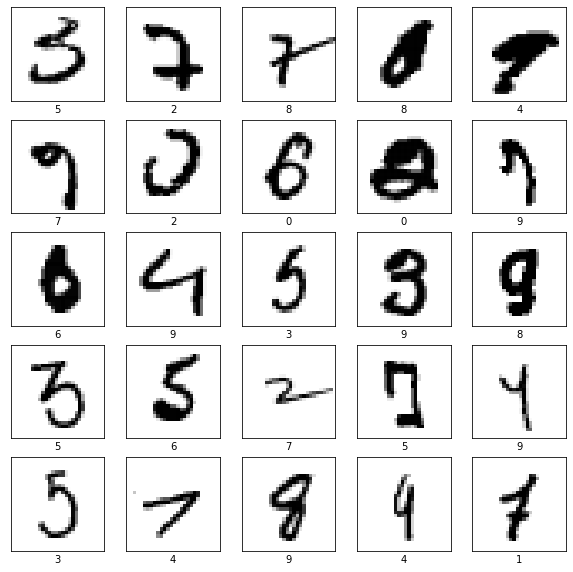

In [ ]:
incorrects = np.nonzero(y_pred != y_train)
x_incorrect = x_train[incorrects]
y_incorrect = y_pred[incorrects]
plt.figure(figsize=(10,10))
np.random.seed(1)
for i in range(25):
    rn = np.random.randint(x_incorrect.shape[0])
    plt.subplot(5,5,i +1 )
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_incorrect[rn], cmap=plt.cm.binary)
    plt.xlabel(y_incorrect[rn])
plt.show()

We can see three type of errors:


1.   An error due to incomprehensible characters for a human too. It's impossible to remove it.
2.   An error due to ambiguous characters. We can try to solve it with another algorithm.
3. An error related to the algorithm. In this case the problem is not in the dataset but with the classification itself. 



# 4. **A Data Augmentation trial**

We will try now to do some data augmentation. This process consists in creating manually some other images hoping to help the algorithm to better forecast. 

The technique we can use are a lot but due to the fact that usually a problem of Fully connected neural network is to rely too much on the pixel position, we will try to move them. Therefor for each image in the training set we will create four shifted copies of the image, shifting of one pixel to the right, to the left, up or down.

Let's see the effect.

In [ ]:
from scipy.ndimage.interpolation import shift 

We first show the original image.

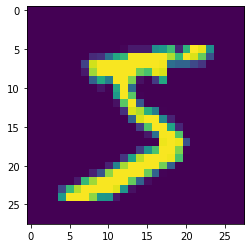

In [ ]:
plt.imshow((x_train[0]))

We then move by 4 pixels to the right.

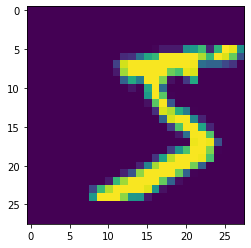

In [ ]:
plt.imshow(shift(x_train[0], [0,4], cval = 0))

In [ ]:
We then move down by 4 pixels.

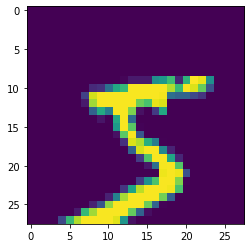

In [ ]:
plt.imshow(shift(x_train[0], [4,0], cval = 0))

We now create the 4 new training set, we bind them together and shuffle them.

In [ ]:
def shift_image(image, dx, dy):
  shift(image, [0,1], cval = 0, mode = "constant")
  return image

In [ ]:
x_train_augmented = [image for image in x_train]
y_train_augmented = [label for label in y_train]

In [ ]:
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
  for image, label in zip(x_train, y_train):
    x_train_augmented.append(shift_image(image, dx, dy))
    y_train_augmented.append(label)
     

In [ ]:
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(x_train_augmented))
x_train_augmented = x_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Let's train now both the model with augmented and not augmented dataset and see the results.

In [ ]:
myFinalModelNoAug = myModel4LBatFinal()
myFinalModelNoAug.fit(x_train, y_train, validation_split = 0.33, epochs = 20, batch_size = 128)

Epoch 1/20
315/315 [==============================] - 1s 4ms/step - loss: 1.6647 - accuracy: 0.7960 - val_loss: 1.5313 - val_accuracy: 0.9234
Epoch 2/20
315/315 [==============================] - 1s 3ms/step - loss: 1.5354 - accuracy: 0.9244 - val_loss: 1.5140 - val_accuracy: 0.9423
Epoch 3/20
315/315 [==============================] - 1s 4ms/step - loss: 1.5181 - accuracy: 0.9410 - val_loss: 1.5071 - val_accuracy: 0.9516
Epoch 4/20
315/315 [==============================] - 1s 3ms/step - loss: 1.5096 - accuracy: 0.9513 - val_loss: 1.5037 - val_accuracy: 0.9546
Epoch 5/20
315/315 [==============================] - 1s 3ms/step - loss: 1.5065 - accuracy: 0.9542 - val_loss: 1.4997 - val_accuracy: 0.9605
Epoch 6/20
315/315 [==============================] - 1s 3ms/step - loss: 1.5000 - accuracy: 0.9627 - val_loss: 1.4986 - val_accuracy: 0.9628
Epoch 7/20
315/315 [==============================] - 1s 3ms/step - loss: 1.4979 - accuracy: 0.9652 - val_loss: 1.4964 - val_accuracy: 0.9660
Epoch 

In [ ]:
myFinalModelAug = myModel4LBatFinal()
historyAug =  myFinalModelAug.fit(x_train_augmented, y_train_augmented, validation_split = 0.33, epochs = 20, batch_size = 128)

Epoch 1/20
1571/1571 [==============================] - 6s 4ms/step - loss: 1.5465 - accuracy: 0.9140 - val_loss: 1.4958 - val_accuracy: 0.9664
Epoch 2/20
1571/1571 [==============================] - 5s 3ms/step - loss: 1.4976 - accuracy: 0.9653 - val_loss: 1.4880 - val_accuracy: 0.9756
Epoch 3/20
1571/1571 [==============================] - 5s 3ms/step - loss: 1.4909 - accuracy: 0.9743 - val_loss: 1.4827 - val_accuracy: 0.9836
Epoch 4/20
1571/1571 [==============================] - 5s 3ms/step - loss: 1.4883 - accuracy: 0.9771 - val_loss: 1.4820 - val_accuracy: 0.9852
Epoch 5/20
1571/1571 [==============================] - 5s 3ms/step - loss: 1.4865 - accuracy: 0.9796 - val_loss: 1.4806 - val_accuracy: 0.9866
Epoch 6/20
1571/1571 [==============================] - 5s 3ms/step - loss: 1.4853 - accuracy: 0.9811 - val_loss: 1.4795 - val_accuracy: 0.9891
Epoch 7/20
1571/1571 [==============================] - 5s 3ms/step - loss: 1.4844 - accuracy: 0.9826 - val_loss: 1.4792 - val_accuracy:

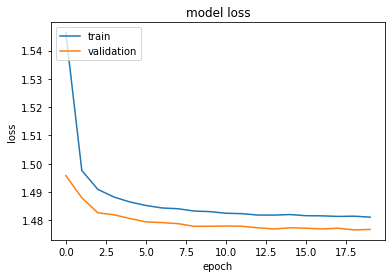

In [ ]:
plt.plot(historyAug.history['loss'])
plt.plot(historyAug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

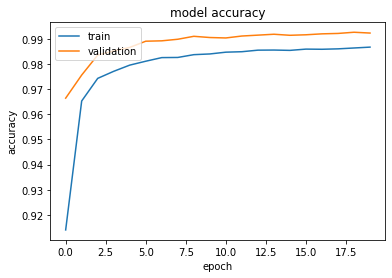

In [ ]:
plt.plot(historyAug.history['accuracy'])
plt.plot(historyAug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We see that we don't need more epochs to train our model.

We also see that we have improved a lot the accuracy of our model. 

In [ ]:
myFinalModelNoAug.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.4887 - accuracy: 0.9758


[1.488709807395935, 0.9757999777793884]

In [ ]:
myFinalModelAug.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.4859 - accuracy: 0.9802


[1.4859118461608887, 0.9801999926567078]

So we have gained a $0.5%$ of accuracy with the data augmentation technique.

# 5. **What to do next?**

In this guide we have seen a lot of models, we have tried different techniques to improve our algorithms and seen the results. 

The scope wasn't to find the best model over all the models present in the literature but over a restricted range of possibilities. The main choice was to study some classical methods like logistic classifier, random forest and fully connected neural network and tune them. 

We have seen that the random forest has very good results w.r.t. the neural network and it's simpler, so this can be a factor to consider for a general deployment. 

But in general we would also see the type of errors committed by the algorithms: maybe the misclassification of some characters is worst than another. This part is totally left to the modeller. 

In this case we can see from the confusion matrices that the random forest classify worst some characters than the neural network. We can see a bias in this case. So in this case we can prefer the neural network.

We have also seen that some character are very easy to confuse and so we can try something else to better recognize these characters.

Finally we know that the best answer to the image classification problem is in general a CNN architecture. We don't have studied this architecture here because it would have required a lot of explainations and we already have done a lot with these models.

This archicture is very interesting because w.r.t. the classical methods it adds some feature engineering integrated in the architecture itself and this can be very useful to better detect the different numbers. 

So it could be very interesting to study this architecture as well as trying all the techniques we have seen here and other one like batch normalization, early stopping and other data augmentation techniques.
